<a href="https://colab.research.google.com/github/pulindu-seniya-silva/Fake-News-Detection-NLP/blob/different-dataset-test/Fake_News_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
#installing NLTK for text preprocessing
!pip install nltk


In [7]:
 #install Hugging Face 'transformers' library for BERT/deep Learning
!pip install transformers

# Loading the dataset

In [8]:

#Data Manipulation and Exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
# Mount Google Drive (if the file is there)
from google.colab import drive
drive.mount('/content/drive')

# 1. Load both files
# Added engine='python' to handle potential parsing issues with CSV files
df_fake = pd.read_csv('Fake.csv', engine='python', encoding='utf-8', on_bad_lines='skip')
df_true = pd.read_csv('True.csv', engine='python', encoding='utf-8', on_bad_lines='skip')

# 2. Assign labels manually (since the files don't have a 'label' column)
df_fake['label'] = 1  # 1 for Fake
df_true['label'] = 0  # 0 for Real

# 3. Combine them into one big dataframe
df = pd.concat([df_fake, df_true], axis=0).reset_index(drop=True)

# 4. Shuffle the data (Very Important!)
# If you don't shuffle, the model sees all Fake news first and then all Real news,
# which confuses the training process.
from sklearn.utils import shuffle
df = shuffle(df).reset_index(drop=True)

print(f"Total rows: {len(df)}")
print(df['label'].value_counts())
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total rows: 17815
label
0    8983
1    8832
Name: count, dtype: int64


,title,text,subject,date,label
0,Bill Maher Did NOT Disappoint In His Reaction...,There s really no better person to roast Sarah...,News,"January 23, 2016",1
1,WOW: Trump Jr. Just Offered To Ship Black Peo...,You know what might make the recent scandal su...,News,"February 29, 2016",1
2,WATCH: Trump Literally Promises To Gut Financ...,Donald Trump was blunt when he explained why h...,News,"February 5, 2017",1
3,Sean Spicer: Donald Trump Does Not Own A Bath...,White House press secretary of Alternative Fac...,News,"February 6, 2017",1
4,"On The Day A Hurricane Is About To Hit Land, ...",Donald Trump is about to get his first real te...,News,"August 25, 2017",1


In [9]:
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17815 entries, 0 to 17814
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    17815 non-null  object
 1   text     17815 non-null  object
 2   subject  17815 non-null  object
 3   date     17815 non-null  object
 4   label    17815 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 696.0+ KB


In [10]:
#import libraries
#Natural Language Processing (Text Cleaning and Preprocessing)
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

#Machine Learning (Feature Extraction and Models)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#Downloard NLTK resources
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Preliminary Data Inspection

In [11]:
#Check the total number of rows and columns
print(f"\nTotal rows and columns: {df.shape}")


Total rows and columns: (17815, 5)


In [12]:
#Check for missing values in each column
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
title      0
text       0
subject    0
date       0
label      0
dtype: int64


# imputation (Handling Missing Vlaues)

In [17]:
#Re-check for nulls to confirm
print("\nMissing values after imputation:")
print(df.isnull().sum())


Missing values after imputation:
title        0
text         0
subject      0
date         0
label        0
full_text    0
dtype: int64


# Feature Selection

In [15]:
#Combine 'title' and 'text' into a single 'full_text' feature
#using a space (' ') as separator
df['full_text'] = df['title'] + " " + df['text']

# Quick check to make sure there are no empty rows
df = df.dropna(subset=['full_text'])

# Only map if the labels are still strings
if df['label'].dtype == 'object':
    df['label'] = df['label'].astype(str).str.strip().str.lower().map({'fake': 1, 'real': 0})

# Drop any rows that failed to map to avoid crashing the model
df = df.dropna(subset=['label'])
df['label'] = df['label'].astype(int)
print(df['label'].value_counts())

#Display the result
print("\nDataFrame after combining text and mapping label:")
print(df[['full_text', 'label']].head())

label
0    8983
1    8832
Name: count, dtype: int64

DataFrame after combining text and mapping label:
                                           full_text  label
0   Bill Maher Did NOT Disappoint In His Reaction...      1
1   WOW: Trump Jr. Just Offered To Ship Black Peo...      1
2   WATCH: Trump Literally Promises To Gut Financ...      1
3   Sean Spicer: Donald Trump Does Not Own A Bath...      1
4   On The Day A Hurricane Is About To Hit Land, ...      1


# Exploratory Data Analysis(EDA)- Class Imbalance

In [16]:
#Check the distribution of the target variable ('label')
print("\nDistribution of News Labels (0=Real, 1=Fake):")
print((df['label']).value_counts())


Distribution of News Labels (0=Real, 1=Fake):
label
0    8983
1    8832
Name: count, dtype: int64


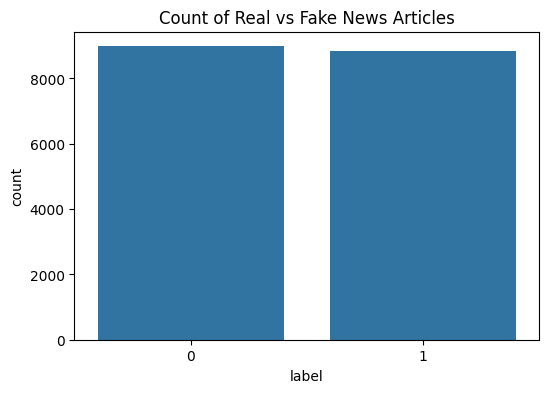

In [18]:
#visualize the distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Count of Real vs Fake News Articles')
plt.show()

# Text Preprocessing and Tokenization

In [19]:
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Define the Cleaning function
# we rely on the TfidVectorizer's built-in 'stop_words' functionality later,
# so we only perform essential cleaning here.

def clean_text(text):
  #convert text to lowercase
  text = text.lower()

  # Remove special characters, numbers, and punctuation (keep only letters and spaces)
  # Replace anything that is NOT a letter or a space with a single space
  text = re.sub(r'[^a-zA-Z\s]', ' ', text)

  # Replace multiple spaces with a single space and trim surrounding whitespace
  text = re.sub(r'\s+', ' ', text).strip()

  # Filter out single-character word (like 'a' or 'i' if they somehow survived stop word removal)
  words = [word for word in text.split() if len(word) > 1]

  return ' '.join(words)

# Apply the cleaning function to the 'full_text' column
df['cleaned_text'] = df['full_text'].apply(clean_text)

print("--- Text Cleaning Applied ---")
print(f"Original Text Sample: {df['full_text'].iloc[0][:100]}...")
print(f"Cleaned Text Sample: {df['cleaned_text'].iloc[0][:100]}...")




--- Text Cleaning Applied ---
Original Text Sample:  Bill Maher Did NOT Disappoint In His Reaction To Sarah Palin’s Endorsement Of Trump (VIDEO) There s...
Cleaned Text Sample: bill maher did not disappoint in his reaction to sarah palin endorsement of trump video there really...


# Data Splitting (Train-Test Split)

In [20]:
import re
from nltk.corpus import stopwords

# Ensure stopwords are available (if not downloaded before)
# This is already done in cell -aqUv-7YQATj, but included here for self-containment if this cell is run independently.
# nltk.download('stopwords') # Uncomment if you encounter NLTK resource errors when running this cell alone
stop_words = set(stopwords.words('english'))

def advanced_clean(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text) # Remove numbers and punctuation
    words = text.split()
    # Remove stop words (the, is, at) and very short words
    words = [w for w in words if w not in stop_words and len(w) > 2]
    return " ".join(words)

# Apply advanced cleaning to create the necessary feature columns
df['cleaned_text'] = df['full_text'].apply(advanced_clean)
df['text_for_ml'] = df['full_text'].apply(advanced_clean)  # classical ML features
df['text_for_bert'] = df['full_text']                      # raw text for BERT

# Define feature sets and the target variable
X = df['cleaned_text'] # This is the primary feature set for TF-IDF/PAC
X_ml = df['text_for_ml']
X_bert = df['text_for_bert']
y = df['label']

# The 'label' column was already cleaned for NaNs in cell nHnnc_i8ga0U, so no need for combined_data and dropna here.

# Split the data, ensuring the label distribution is maintained (stratify=y)
# This sets the canonical y_train and y_test for further model evaluation.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split for the classical ML feature set, reusing the same y for stratification
# Using _, _ for y_train_ml and y_test_ml to avoid overwriting the base y_train, y_test variables.
X_train_ml, X_test_ml, _, _ = train_test_split(
    X_ml, y, test_size=0.2, random_state=42, stratify=y
)

# Split for the BERT feature set, reusing the same y for stratification
X_train_bert, X_test_bert, _, _ = train_test_split(
    X_bert, y, test_size=0.2, random_state=42, stratify=y
)


print("--- Data Splitting Complete ---")
print(f"Total sample: {len(X)}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}\n")

--- Data Splitting Complete ---
Total sample: 17815
Training samples: 14252
Testing samples: 3563



# Advanced cleaning

In [21]:
import re
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def advanced_clean(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text) # Remove numbers and punctuation
    words = text.split()
    # Remove stop words (the, is, at) and very short words
    words = [w for w in words if w not in stop_words and len(w) > 2]
    return " ".join(words)

df['cleaned_text'] = df['full_text'].apply(advanced_clean)

df['text_for_ml'] = df['full_text'].apply(advanced_clean)  # classical ML
df['text_for_bert'] = df['full_text']                      # raw text


# Feature Engineering (TF-IDF Vectorization)

In [22]:
# 1. Intialize the TF-IDF Vectorizer
# Change your TfidfVectorizer to include pairs of words
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7, ngram_range=(1, 2), min_df=5)

In [23]:
# 2. Fit and Transform (CRITICAL step: Fit only on Training Data!)
# .fit() learns the vocabulary from X_train
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [24]:
# 3. Transform (Apply the vocabulary learned from X_train to the test data)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [25]:
print("--- TF-IDF Vectorization Complete ---")
print(f"X_train_tfidf shape: {X_train_tfidf.shape}")
print(f"X_test_tfidf shape: {X_test_tfidf.shape}")
print(f"Vocabulary size (number of features): {len(tfidf_vectorizer.get_feature_names_out())}")

--- TF-IDF Vectorization Complete ---
X_train_tfidf shape: (14252, 92372)
X_test_tfidf shape: (3563, 92372)
Vocabulary size (number of features): 92372


# Model Development and Training

In [26]:
from sklearn.linear_model import LogisticRegression

# 1. Improved Vectorizer (looks for 1-word and 2-word patterns) specifically for Logistic Regression
tfidf_lr = TfidfVectorizer(max_df=0.7, min_df=5, ngram_range=(1, 2))
X_train_tfidf_lr = tfidf_lr.fit_transform(X_train)
X_test_tfidf_lr = tfidf_lr.transform(X_test)

# 2. Use Logistic Regression (often more stable than PAC)
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf_lr, y_train)

# 3. Predict and check
y_pred_lr = model.predict(X_test_tfidf_lr)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr)*100:.2f}%")

Logistic Regression Accuracy: 99.44%


# Save the model

In [27]:
import pickle

# 1. Save the trained Logistic Regression Model (assuming this was the intended model as 'model' was trained)
# 'wb' stands for "Write Binary"
with open('fake_news_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# 2. Save the TF-IDF Vectorizer
# This is crucial! Without this, you cannot transform new text for prediction.
with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(tfidf_vectorizer, vectorizer_file)

print("Success! Both the model and vectorizer have been saved as .pkl files.")

Success! Both the model and vectorizer have been saved as .pkl files.


In [28]:
# Check if labels are actually 0 and 1
print(df['label'].value_counts())

label
0    8983
1    8832
Name: count, dtype: int64


In [29]:
pac = PassiveAggressiveClassifier(
    C=0.5,             # Regularization strength
    max_iter=100,      # Give it more time to learn
    validation_fraction=0.1,
    n_iter_no_change=5, # Stop when it stops improving
    random_state=42
)
pac.fit(X_train_tfidf, y_train)

PassiveAggressiveClassifier(C=0.5, max_iter=100, random_state=42)

In [30]:
!pip install transformers[torch] datasets
from transformers import BertTokenizer, BertForSequenceClassification

# Load the brain of the model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
# Check for empty strings after cleaning
empty_rows = df[df['cleaned_text'] == ''].shape[0]
print(f"Empty text rows: {empty_rows}")

# Check class balance in Training set
print("Training label distribution:")
print(y_train.value_counts(normalize=True))

Empty text rows: 0
Training label distribution:
label
0    0.50421
1    0.49579
Name: proportion, dtype: float64


# Testing and Evaluation

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Ensure X_test_tfidf has the correct number of features by re-transforming with the original vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# 1. Predict (The "Exam" Step)
# We ask the model to guess the labels for the unseen test data
y_pred = pac.predict(X_test_tfidf)

# 2. Calculate Accuracy
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(score*100, 2)}%')

# 3. Create the Confusion Matrix
# This shows: [ [True Positives, False Negatives], [False Positives, True Negatives] ]
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 4. Detailed Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 99.89%

Confusion Matrix:
[[1793    4]
 [   0 1766]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1797
           1       1.00      1.00      1.00      1766

    accuracy                           1.00      3563
   macro avg       1.00      1.00      1.00      3563
weighted avg       1.00      1.00      1.00      3563

